In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
dataset=pd.read_csv('price_prediction_new.csv')
df=dataset.drop(['train_id','Unnamed: 10'], axis=1)
df.head(2)

,name,item_condition_id,category_name,brand_name,number_of_item_sold,days_launch,price,shipping,item_description
0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,1214,67,10.0,1,No description yet
1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,2366,41,52.0,0,This keyboard is in great condition and works ...


In [3]:
def handle_missing(dataset):
    dataset.category_name.fillna(value="missing", inplace=True)
    dataset.brand_name.fillna(value="missing", inplace=True)
    dataset.item_description.fillna(value="missing", inplace=True)
    return (dataset)

data = handle_missing(df)

In [4]:
#PROCESS CATEGORICAL DATA
le = LabelEncoder()
data.category_name = le.fit_transform(data.category_name)
data.brand_name = le.fit_transform(data.brand_name)
data.head(2)

,name,item_condition_id,category_name,brand_name,number_of_item_sold,days_launch,price,shipping,item_description
0,MLB Cincinnati Reds T Shirt Size XL,3,296,552,1214,67,10.0,1,No description yet
1,Razer BlackWidow Chroma Keyboard,3,52,412,2366,41,52.0,0,This keyboard is in great condition and works ...


In [5]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
columns=['number_of_item_sold','days_launch']
data[columns] = sc.fit_transform(data[columns])
sc_price=StandardScaler()
data[['price']] = sc_price.fit_transform(data[['price']])

In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
raw_text = np.hstack([data.item_description.str.lower(), data.name.str.lower()])
tokenizer = Tokenizer()
tokenizer.fit_on_texts(raw_text)
data["seq_item_description"] = tokenizer.texts_to_sequences(data.item_description.str.lower())
data["seq_name"] = tokenizer.texts_to_sequences(data.name.str.lower())
data.head(3)

,name,item_condition_id,category_name,brand_name,number_of_item_sold,days_launch,price,shipping,item_description,seq_item_description,seq_name
0,MLB Cincinnati Reds T Shirt Size XL,3,296,552,-0.503870,0.726913,-0.400241,1,No description yet,"[12, 62, 71]","[2955, 7310, 4207, 256, 89, 7, 203]"
1,Razer BlackWidow Chroma Keyboard,3,52,412,1.510132,-0.388936,0.621458,0,This keyboard is in great condition and works ...,"[24, 2005, 10, 6, 41, 18, 1, 183, 49, 21, 909,...","[3568, 7311, 12164, 2005]"
2,AVA-VIV Blouse,1,500,474,0.943694,-1.161447,-0.400241,1,Adorable top with a hint of lace and a key hol...,"[771, 58, 9, 4, 4230, 11, 198, 1, 4, 735, 1185...","[12165, 12166, 490]"


In [7]:
max_name_seq_length = data['seq_name'].map(len).max()
max_seq_item_description_length = data['seq_item_description'].map(len).max()
MAX_TEXT = np.max(np.concatenate([np.concatenate(data.seq_name),np.concatenate(data.seq_name)]))+1
MAX_CATEGORY = np.max(np.concatenate([data.category_name]))+1
MAX_BRAND = np.max(np.concatenate([data.brand_name]))+1
MAX_CONDITION = np.max(np.concatenate([data.item_condition_id]))+1

In [8]:
print("max name seq length "+str(max_name_seq_length))
print("max item desc seq length "+str(max_seq_item_description_length))
print("max text "+str(MAX_TEXT))
print("max category "+str(MAX_CATEGORY))
print("max brand "+str(MAX_BRAND))
print("max max condition "+str(MAX_CONDITION))

max name seq length 10
max item desc seq length 194
max text 13568
max category 532
max brand 558
max max condition 6


In [9]:
# split data
dataset=data.drop(['name','item_description'], axis=1)
data_train, data_test = train_test_split(dataset, random_state=123, train_size=0.8)

In [10]:
from keras.preprocessing.sequence import pad_sequences

def get_keras_data(dataset):
    X = {
        'name': pad_sequences(dataset['seq_name'], maxlen=10, padding='post'),
        'item_desc': pad_sequences(dataset['seq_item_description'], maxlen=50, padding='post'),
        'brand_name': np.array(dataset['brand_name']),
        'category_name': np.array(dataset['category_name']),
        'item_condition': np.array(dataset['item_condition_id']),
        'shipping': np.array(dataset['shipping']),
        'number_of_item_sold': np.array(dataset['number_of_item_sold']),
        'days_launch': np.array(dataset['days_launch'])
    }
    return X
X_train = get_keras_data(data_train)
X_test = get_keras_data(data_test)
y_train = data_train['price'].values
y_test = data_test['price'].values

In [11]:
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.layers import Input, Embedding, GRU, Dense, Dropout, Flatten, BatchNormalization, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

def build_model(hp):
    # Hyperparameters
    learning_rate = hp.Float('learning_rate', min_value=0.0001, max_value=0.01, sampling='log')
    l2_regularizer = hp.Float('l2_regularizer', min_value=0.0001, max_value=0.01, sampling='log')
    kernel_initializer = hp.Choice('kernel_initializer', values=['he_uniform', 'glorot_uniform', 'lecun_normal'])
    activation = hp.Choice('activation', values=['relu', 'tanh'])
    dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)
    GRU_units = hp.Int('GRU_units', min_value=32, max_value=256, step=32)
    dense_units = hp.Int('dense_units', min_value=32, max_value=128, step=32)

    # Inputs 
    input_name = Input(shape=(10,), name='name')
    input_item_desc = Input(shape=(50,), name='item_desc')
    input_brand = Input(shape=(1,), name='brand_name')
    input_category = Input(shape=(1,), name='category_name')
    input_condition = Input(shape=(1,), name='item_condition')
    input_shipping = Input(shape=(1,), name='shipping')
    input_num_sold = Input(shape=(1,), name='number_of_item_sold')
    input_days_launch = Input(shape=(1,), name='days_launch')

    # Embedding 
    embedding_name = Embedding(input_dim=MAX_TEXT, output_dim=50)(input_name)
    embedding_item_desc = Embedding(input_dim=MAX_TEXT, output_dim=50)(input_item_desc)

    # GRU Layers
    rnn_layer_item_desc = GRU(GRU_units, return_sequences=False, 
                               kernel_initializer=kernel_initializer,
                               kernel_regularizer=l2(l2_regularizer))(embedding_item_desc)
    rnn_layer_item_desc = Dropout(dropout_rate)(rnn_layer_item_desc)

    rnn_layer_name = GRU(GRU_units, return_sequences=False, 
                          kernel_initializer=kernel_initializer,
                          kernel_regularizer=l2(l2_regularizer))(embedding_name)
    rnn_layer_name = Dropout(dropout_rate)(rnn_layer_name)

    # Categorical Embedding layers
    embedding_brand = Embedding(input_dim=1000, output_dim=10)(input_brand)
    embedding_category = Embedding(input_dim=1000, output_dim=10)(input_category)
    embedding_condition = Embedding(input_dim=10, output_dim=5)(input_condition)
    embedding_shipping = Embedding(input_dim=10, output_dim=5)(input_shipping)   
    flatten_brand = Flatten()(embedding_brand)
    flatten_category = Flatten()(embedding_category)
    flatten_condition = Flatten()(embedding_condition)
    flatten_shipping = Flatten()(embedding_shipping)

    # Concatenate
    concat = concatenate([rnn_layer_item_desc, rnn_layer_name, flatten_brand, flatten_category, 
                          flatten_condition, flatten_shipping, input_num_sold, input_days_launch])
   
    dense1 = Dense(dense_units, activation=activation, kernel_initializer=kernel_initializer, 
                   kernel_regularizer=l2(l2_regularizer))(concat)
    dense1 = Dropout(dropout_rate)(dense1)
    
    dense2 = Dense(dense_units, activation=activation, kernel_initializer=kernel_initializer, 
                   kernel_regularizer=l2(l2_regularizer))(dense1)
    dense2 = Dropout(dropout_rate)(dense2)
    
    output = Dense(1)(dense2)  
   
    model = Model(inputs=[input_name, input_item_desc, input_brand, input_category, 
                          input_condition, input_shipping, input_num_sold, input_days_launch],
                  outputs=output)
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    
    return model
    

In [15]:
# Create the tuner
tuner = kt.RandomSearch(
    build_model,  # Model-building function
    objective='val_loss',  # Objective to optimize
    max_trials=10,  # Number of trials to try
    directory='exp',
    )
tuner.search(X_train,y_train , epochs=30, validation_data=(X_test,y_test))

Trial 10 Complete [00h 03m 08s]
val_loss: 0.5221289992332458

Best val_loss So Far: 0.3645792603492737
Total elapsed time: 00h 58m 52s


In [16]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps.values

{'learning_rate': 0.001704339592386605,
 'l2_regularizer': 0.00010991920429240618,
 'kernel_initializer': 'glorot_uniform',
 'activation': 'relu',
 'dropout_rate': 0.30000000000000004,
 'GRU_units': 64,
 'dense_units': 32}

In [17]:
best_model = tuner.get_best_models(num_models=1)[0]

In [18]:
val_loss, val_mae = best_model.evaluate(X_test, y_test)
print("\nBest Model Validation mae:", val_mae)
print("\nBest Model Validation Loss:", val_loss) 

36/36 [==============================] - 5s 14ms/step - loss: 0.3646 - mae: 0.3233

Best Model Validation mae: 0.3233128488063812

Best Model Validation Loss: 0.3645792603492737


In [26]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=5,          
    restore_best_weights=True  
)

In [27]:
history_best = best_model.fit( X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/100
143/143 [==============================] - 6s 43ms/step - loss: 0.2094 - mae: 0.1604 - val_loss: 0.5506 - val_mae: 0.4145
Epoch 2/100
143/143 [==============================] - 6s 42ms/step - loss: 0.1474 - mae: 0.1497 - val_loss: 0.5313 - val_mae: 0.4162
Epoch 3/100
143/143 [==============================] - 5s 36ms/step - loss: 0.0955 - mae: 0.1468 - val_loss: 0.5277 - val_mae: 0.4157
Epoch 4/100
143/143 [==============================] - 5s 35ms/step - loss: 0.1358 - mae: 0.1514 - val_loss: 0.5592 - val_mae: 0.4150
Epoch 5/100
143/143 [==============================] - 5s 34ms/step - loss: 0.0957 - mae: 0.1500 - val_loss: 0.5323 - val_mae: 0.4232
Epoch 6/100
143/143 [==============================] - 6s 39ms/step - loss: 0.0836 - mae: 0.1409 - val_loss: 0.5307 - val_mae: 0.4145
Epoch 7/100
143/143 [==============================] - 6s 42ms/step - loss: 0.1169 - mae: 0.1461 - val_loss: 0.5418 - val_mae: 0.4270
Epoch 8/100
143/143 [==============================] - 6s 39ms

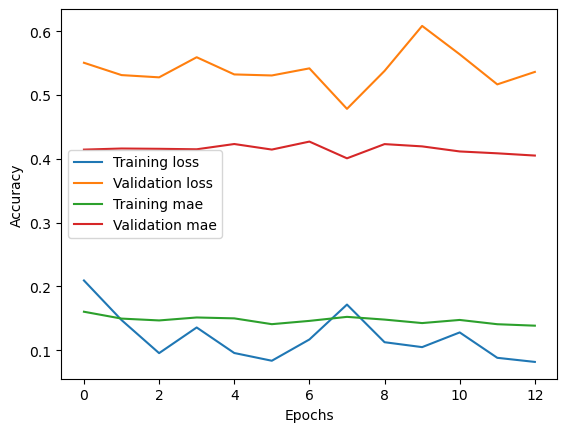

In [28]:
# Graph plot
import matplotlib.pyplot as plt
plt.plot(best_model.history.history['loss'], label='Training loss')
plt.plot(best_model.history.history['val_loss'], label='Validation loss')
plt.plot(best_model.history.history['mae'], label='Training mae')
plt.plot(best_model.history.history['val_mae'], label='Validation mae')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [29]:
val_preds = best_model.predict(X_test)

36/36 [==============================] - 0s 11ms/step


In [30]:
val_preds1 = sc_price.inverse_transform(val_preds)

In [31]:
print(val_preds1)

[[27.042336]
 [39.265736]
 [34.331177]
 ...
 [20.671366]
 [25.81247 ]
 [34.20688 ]]
